# Setup

In [1]:
import json
import os
import sys

sys.path.append('..')

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import roc_curve, recall_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

from pymer4.models import Lmer

from utils import read_csv_non_utf, true_skill_statistic, test_thresholds, ratios_to_DI_cats

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [3]:
# Reading in data as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)
ben_lop2019.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


# Fitting a hurdle model

- Currently, I'm ignoring the random effects component of the model. I think `statsmodels` implements [mixed linear models](https://www.statsmodels.org/stable/mixed_linear.html).
   - [This site](https://geoffruddock.com/building-a-hurdle-regression-estimator-in-scikit-learn/) may be helpful in building an `sklearn` type estimator to fit into a cross-validation procedure.
- Just fitting using the results of their model selection procedure, i.e., only the input variables that they found to be the most important using a [BIC criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion).

Things to try:
- [x] Implement cross-validation
- [x] Model evaluation using the three defaunation categories and using their metrics
- [ ] Figure out what sensitivity and specificity mean in this context (3 defaunation categories)...
- [ ] Try to match their model as closely as possible (mixed effect model, REML for optimization)
   - May need to move over to statsmodels to do this...
- [ ] Try to recover threshold tuning approach for just the classifier following "Combined effects of land use and hunting on distributions of tropical mammals" ([code](https://lifesciences.datastations.nl/file.xhtml?fileId=6882&version=2.0&toolType=PREVIEW))
   - May just be helpful to try running the R code from scratch to see if you get the same thing... 

## Helper functions & classes

### Current helper functions

In [10]:
def get_zero_nonzero_datasets(pp_data, pred = True):   
    # Grabbing needed predictors for each model
    indicator_columns = ['Country', 'Species', 'Study']
    nonzero_columns = ['BM', 'DistKm', 'DistKm^2', 'PopDens', 'PopDens^2', 'BMxDistKm']
    zero_columns = ['BM', 'DistKm', 'DistKm^2', 'PopDens', 'Stunting', 'Reserve']
    
    X_nonzero = pp_data[nonzero_columns].copy(deep = True)
    X_zero = pp_data[zero_columns].copy(deep = True)

    for col in indicator_columns:
        X_nonzero = pd.concat((X_nonzero, pp_data.filter(like = col)), axis = 1)
        X_zero = pd.concat((X_zero, pp_data.filter(like = col)), axis = 1)
    
    # Extracting the inputs/outputs for each of the models in the case where we have labels
    if not pred:
        ratio = pp_data['ratio'].values
        nonzero_mask = (ratio != 0)
        
        X_nonzero = X_nonzero[nonzero_mask].copy(deep = True)
        
        y_zero = (ratio == 0).astype(int) # the positive class corresponds to local extirpation!
        y_nonzero = np.log(ratio[nonzero_mask].copy())

        return X_zero, y_zero, X_nonzero, y_nonzero

    return X_zero, X_nonzero

In [21]:
def preprocess_data(ben_lop_data, include_indicators = False, include_categorical = False, standardize = False):  
    assert not include_indicators or not include_categorical, 'Cannot include indicators and categorical variables at the same time.'
    
    # Defining the variables needed
    indicator_columns = ['Country', 'Species', 'Study']
    continuous_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'Reserve']
    response_column = 'ratio'
    
    # Grabbing just the continuous variables
    pp_data = ben_lop_data[continuous_columns].copy(deep = True)
    
    # Adding cross terms, indicators, and quadratic terms
    pp_data['DistKm^2'] = pp_data['DistKm'] ** 2
    pp_data['PopDens^2'] = pp_data['PopDens'] ** 2
    pp_data['BMxDistKm'] = pp_data['BM'] * pp_data['DistKm']
    pp_data['Reserve'] = (pp_data['Reserve'] == 'Yes').astype(int)

    # Optionally standardizing continuous predictors
    if standardize:
        reserve = pp_data['Reserve'].copy(deep = True)
        pp_data_scaled = StandardScaler().fit_transform(pp_data)
        pp_data = pd.DataFrame(pp_data_scaled, index = pp_data.index, columns = pp_data.columns)
        pp_data['Reserve'] = reserve

    # Optionally adding indicator (or straight categorical) variables for different groups present in data
    if include_indicators:
        pp_data = pd.concat((pp_data, ben_lop_data[indicator_columns].copy(deep = True)), axis = 1)
        pp_data = pd.get_dummies(pp_data, dtype = float, drop_first = True, columns = indicator_columns)
    elif include_categorical:
        pp_data = pd.concat((pp_data, ben_lop_data[indicator_columns].copy(deep = True)), axis = 1)

    # Add back in the response variable
    pp_data[response_column] = ben_lop_data[response_column]
    
    return pp_data

In [12]:
class HurdleModelEstimator(RegressorMixin, BaseEstimator):
    def __init__(self, zero_model, nonzero_model, prob_thresh = 0.5):
        self.zero_model = zero_model
        self.nonzero_model = nonzero_model
        self.prob_thresh = prob_thresh

    def fit(self, pp_data):
        X_zero, y_zero, X_nonzero, y_nonzero = get_zero_nonzero_datasets(pp_data, pred = False)

        self.nonzero_model.fit(X_nonzero, y_nonzero)
        self.zero_model.fit(X_zero, y_zero)

        return self

    def predict(self, pp_data):
        X_zero, X_nonzero = get_zero_nonzero_datasets(pp_data, pred = True)

        y_pred_zero = self.zero_model.predict_proba(X_zero)[ : , 1] >= self.prob_thresh # hard classification, 1 = local extirpation
        y_pred_nonzero = self.nonzero_model.predict(X_nonzero)

        y_pred = (~y_pred_zero).astype(int) * y_pred_nonzero # if y_pred_zero >= prob_thresh, this is a local extirpation so our prediction should be zero

        return y_pred

## Fitting the model using `sklearn`

Currently, this is a just a fixed effects model, since mixed effects models don't seem to have great support in Python...

In [490]:
# Pre-processing data
pp_data = preprocess_data(ben_lop2019, include_indicators = True, standardize = True)

# Defining sub-models for hurdle model
nonzero_model = Ridge(alpha = 0.5)
zero_model = LogisticRegression(penalty = 'l2', max_iter = 1000) # not sure if they use an l2 penalty, but feels reasonable given number of params
hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, prob_thresh = 0.2)

hurdle_model.fit(pp_data)
y_pred = hurdle_model.predict(pp_data)

# Cross-validation
num_folds = 5
y_pred = cross_val_predict(hurdle_model, pp_data, cv = num_folds)

In [491]:
# Back-transforming to recover actual abundance ratios predicted by the hurdle model
ratio = pp_data['ratio']
pred_ratios = y_pred.copy()
pred_ratios[pred_ratios != 0] = np.exp(pred_ratios[pred_ratios != 0]) # don't need to back-transform predicted extirpations - not RRs!
pred_DI_cats = ratios_to_DI_cats(pred_ratios)
true_DI_cats = ratios_to_DI_cats(ratio)

### Evaluating the `sklearn` hurdle model

In [492]:
# Calculatig metrics to match Benitez-Lopez
balanced_acc = balanced_accuracy_score(true_DI_cats, pred_DI_cats)
pseudo_r2 = np.corrcoef(pred_ratios, ratio)[0, 1] ** 2

print(f'{num_folds}-Fold balanced accuracy: {round(balanced_acc * 100, 2)}%')
print(f'{num_folds}-Fold pseudo-R^2: {round(pseudo_r2, 3)}')

5-Fold balanced accuracy: 44.46%
5-Fold pseudo-R^2: 0.0


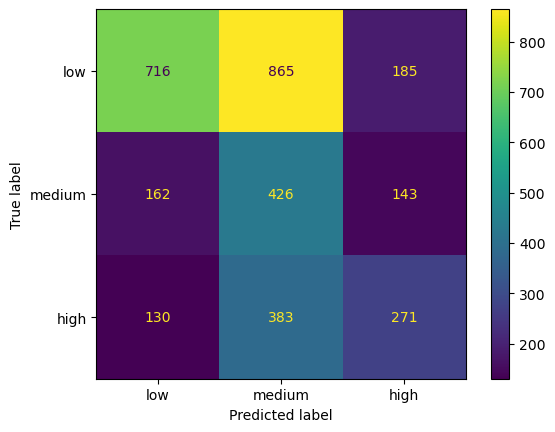

In [494]:
# Confusion matrix
cm = confusion_matrix(true_DI_cats, pred_DI_cats, labels = [0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['low', 'medium', 'high'])

disp.plot()
plt.show()

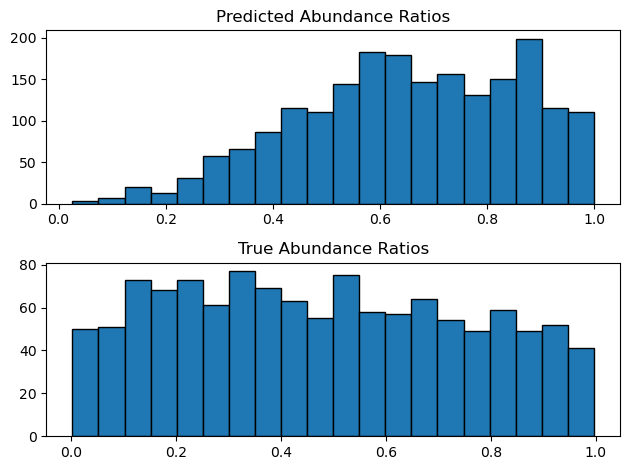

In [495]:
# Comparing the distribution of abundance ratios in the 0-1 range...
fig, ax = plt.subplots(2)

pred_ratios_0_1 = pred_ratios[(pred_ratios < 1) & (pred_ratios > 0)]
ax[0].hist(pred_ratios_0_1, edgecolor = 'black', bins = 20)
ax[0].set_title('Predicted Abundance Ratios')

true_ratios_0_1 = ratio[(ratio < 1) & (ratio > 0)]
ax[1].hist(true_ratios_0_1, edgecolor = 'black', bins = 20)
ax[1].set_title('True Abundance Ratios')

fig.tight_layout()

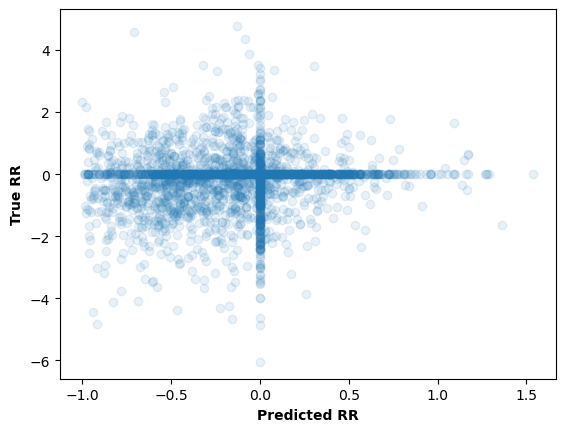

In [496]:
# Regression results, RR
threshold_mask = y_pred[ratio != 0] > -1

rr_true = np.log(ratio[ratio != 0])[threshold_mask]
rr_pred = y_pred[ratio != 0][threshold_mask]

plt.scatter(rr_pred, rr_true, alpha = 0.1)

plt.xlabel('Predicted RR', weight = 'bold')
plt.ylabel('True RR', weight = 'bold');

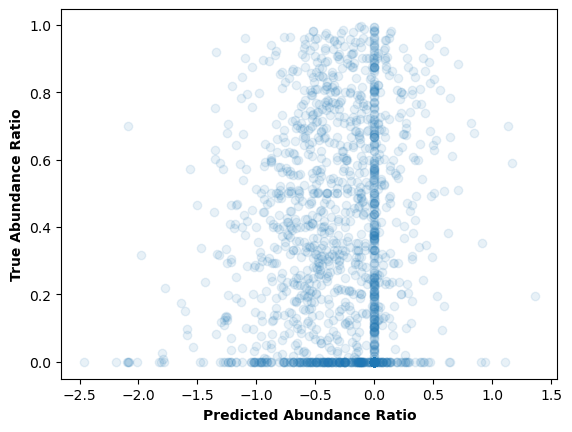

In [498]:
# Regression results, abundance ratio
threshold_mask = ratio < 1

plt.scatter(y_pred[threshold_mask], ratio[threshold_mask], alpha = 0.1)

plt.xlabel('Predicted Abundance Ratio', weight = 'bold')
plt.ylabel('True Abundance Ratio', weight = 'bold');

## Fitting the model using `statsmodels`

Documentation:
- [MixedLM](https://www.statsmodels.org/devel/generated/statsmodels.regression.mixed_linear_model.MixedLM.html)
   - [Usage and comparison to `lme4` in R](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html)
- [BinomialBayesMixedGLM](https://www.statsmodels.org/stable/generated/statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM.html#statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM)

In [215]:
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

In [210]:
ben_lop2019.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


In [225]:
# Extracting the needed data
nonzero_me = ben_lop2019[['BM', 'DistKm', 'PopDens', 'Country', 'Study', 'Species']].copy(deep = True)
nonzero_me['DistKm^2'] = nonzero_me['DistKm'] ** 2
nonzero_me['PopDens^2'] = nonzero_me['PopDens'] ** 2
nonzero_me['BMxDistKm'] = nonzero_me['BM'] * nonzero_me['DistKm']

#  making sure to only grab the nonzero RR values
nonzero_mask = ben_lop2019['ratio'] != 0
nonzero_me_target = ben_lop2019['RR'][nonzero_mask]
nonzero_me = nonzero_me[nonzero_mask]

# Defining variables for fixed and random effects
random_effects = ['Country', 'Study', 'Species']
fixed_effects = list(set(nonzero_me.columns) - set(random_effects)) # everything else...
nonzero_re = nonzero_me[random_effects].copy(deep = True)
nonzero_fe = nonzero_me[fixed_effects].copy(deep = True)

In [227]:
# Specifying the mixed effect Gaussian model
mlm = MixedLM(endog = nonzero_me_target, exog = nonzero_fe, exog_re = nonzero_re, groups = None)

TypeError: 'NoneType' object is not iterable

## Fitting the model using `pymer`

1. Reproduce the binomial extirpation model w/threshold tuning based on the TSS.
2. Reproduce the hurdle model results with both the Gaussian and binomial models.

## Binomial model

Thoughts:
- We can make predictions using the random effects when training/validating on the same dataset, but when we try to generalize we won't be able to include them... will that affect predictive performance substantially?
   - Just a quick check says yes--I just set the `use_rfx` argument to false in the `.predict()` function.
- Still need to try to do this all from scratch using the original dataset instead of the pre-cleaned dataset from Gallego-Zamorano _et al._ (2020).

### Reading in the data

This is both the Gallego-Zamorano _et al._ (2020) and Benitez-Lopez _et al._ (2019) versions--I modified the latter to recover the former!

In [4]:
# Read in the alternate dataset - this should be the same as Benitez-Lopez et al. (2019)!
alt_dataset_fp = '/Users/emiliolr/Desktop/LIFE/benitez_lopez/huntingdb.csv' 
alt_data = read_csv_non_utf(alt_dataset_fp)
alt_data = alt_data.rename(columns = {'PopDensUpd' : 'PopDens'})

alt_data.head()

,Reference,dataset2,Species,BM,DistKm,PopDens,Country,Binomial
0,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-0.823909,-0.017729,Gabon,1
1,"Laurance et al., 2006",1,Loxodonta africana,3.595500,-0.823909,-0.017729,Gabon,1
2,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-0.397940,-0.017729,Gabon,1
3,"Laurance et al., 2006",1,Loxodonta africana,3.595500,-0.397940,-0.017729,Gabon,1
4,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-0.154902,-0.017729,Gabon,1


In [5]:
# Trying to recover the alternate dataset from the original Benitez-Lopez dataset... should be the same!
cols_to_keep = ['Reference', 'Study', 'Species', 'BM', 'DistKm', 'PopDens', 'Country', 'ratio']

#  extract the needed variables
ben_lop2019_sub = ben_lop2019[cols_to_keep].copy(deep = True)
ben_lop2019_sub['Binomial'] = (ben_lop2019_sub['ratio'] > 0).astype(int)
ben_lop2019_sub = ben_lop2019_sub.drop(columns = ['ratio'])

#  rename study column
ben_lop2019_sub = ben_lop2019_sub.rename(columns = {'Study' : 'dataset2'})

#  log10 transform continuous predictors
ben_lop2019_sub.loc[ben_lop2019_sub['PopDens'] == 0, 'PopDens'] = 0.1

cont_pred = ['BM', 'DistKm', 'PopDens']
for pred in cont_pred:
    ben_lop2019_sub[pred] = np.log10(ben_lop2019_sub[pred])

ben_lop2019_sub.head()

,Reference,dataset2,Species,BM,DistKm,PopDens,Country,Binomial
0,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-1.301030,-0.065502,Gabon,1
1,"Laurance et al., 2006",1,Loxodonta africana,3.595500,-1.301030,-0.065502,Gabon,1
2,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-0.522879,-0.065502,Gabon,1
3,"Laurance et al., 2006",1,Loxodonta africana,3.595500,-0.522879,-0.065502,Gabon,1
4,"Laurance et al., 2006",1,"Cephalophus callipygus, C. dorsalis, C. leucog...",1.232234,-0.221849,-0.065502,Gabon,1


In [6]:
# Checking the level of agreement between the two pre-processed datasets
ben_lop2019_sub = ben_lop2019_sub.sort_values(by = ['Reference', 'Species'])
alt_data = alt_data.sort_values(by = ['Reference', 'Species'])

#  looking at response variable
num_disagree = (alt_data['Binomial'] != ben_lop2019_sub['Binomial']).sum()
print(f'Response variable disagreement count: {num_disagree}')
print()

#  looking at continuos predictors
for pred in cont_pred:
    mae = np.mean(np.abs(alt_data[pred] - ben_lop2019_sub[pred]))
    print(f'MAE between datasets for {pred}: {round(mae, 3)}')
print()

#  looking at categorical predictors
cat_pred = ['Species', 'Reference', 'Country']
for pred in cat_pred:
    num_disagree = (alt_data[pred] != ben_lop2019_sub[pred]).sum()
    print(f'{pred} disagreement count: {num_disagree}')

Response variable disagreement count: 0

MAE between datasets for BM: 0.0
MAE between datasets for DistKm: 0.016
MAE between datasets for PopDens: 0.059

Species disagreement count: 0
Reference disagreement count: 0
Country disagreement count: 0


### Specifying, fitting, and predicting with the mixed effects model

In [7]:
# Choosing dataset to use
dataset = alt_data

In [8]:
# Specifying the mixed effects model and fitting to the data using pymer4 
binomial_formula = 'Binomial ~ BM + DistKm + I(DistKm^2) + PopDens + (1|Country) + (1|Species) + (1|dataset2)'

bin_model = Lmer(binomial_formula, data = dataset, family = 'binomial')
bin_model.fit(REML = True)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: Binomial~BM+DistKm+I(DistKm^2)+PopDens+(1|Country)+(1|Species)+(1|dataset2)

Family: binomial	 Inference: parametric

Number of observations: 3281	 Groups: {'Species': 296.0, 'dataset2': 163.0, 'Country': 37.0}

Log-likelihood: -977.528 	 AIC: 1971.055

Random effects:

                 Name    Var    Std
Species   (Intercept)  1.292  1.137
dataset2  (Intercept)  2.359  1.536
Country   (Intercept)  0.574  0.758

No random effect correlations specified

Fixed effects:



/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),2.563,1.778,3.347,0.400,12.973,5.921,28.426,0.928,0.856,0.966,6.404,0.000,***
BM,-0.669,-0.966,-0.371,0.152,0.512,0.381,0.690,0.339,0.276,0.408,-4.406,0.000,***
DistKm,0.732,-0.126,1.590,0.438,2.079,0.882,4.903,0.675,0.469,0.831,1.673,0.094,.
I(DistKm^2),1.897,1.193,2.601,0.359,6.666,3.297,13.479,0.870,0.767,0.931,5.281,0.000,***
PopDens,-0.578,-1.051,-0.104,0.242,0.561,0.349,0.901,0.359,0.259,0.474,-2.390,0.017,*


In [9]:
# Making predictions with the model and caluculating the optimal threshold
y_pred = bin_model.predict(dataset, use_rfx = True, skip_data_checks = True, verify_predictions = False)
y_pred = np.asarray(y_pred)
y_true = dataset['Binomial']

opt_thresh, metrics = test_thresholds(y_pred, y_true)
print(f'Best threshold was found to be {round(opt_thresh, 3)} with a TSS of {round(np.max(metrics["TSS"]), 3)}')
metrics

Best threshold was found to be 0.85 with a TSS of 0.713


,threshold,TSS,sensitivity,specificity
0,0.00,0.000000,1.000000,0.000000
1,0.05,0.000000,1.000000,0.000000
2,0.10,0.000000,1.000000,0.000000
3,0.15,0.019608,1.000000,0.019608
4,0.20,0.044118,1.000000,0.044118
5,0.25,0.080882,1.000000,0.080882
6,0.30,0.114152,0.998956,0.115196
7,0.35,0.168088,0.996519,0.171569
8,0.40,0.221313,0.995823,0.225490
9,0.45,0.285401,0.993735,0.291667


In [10]:
# The maximum sensitivity value is slightly different, but my guess is they ignored the places where
#  sensitivity=1.0... if you look where sensitivity is first <1.0, you get their reported value for TSS!
max_sens = metrics['TSS'].iloc[np.argmax(metrics['sensitivity'])]
max_spec = metrics['TSS'].iloc[np.argmax(metrics['specificity'])]

print(f"TSS when choosing the threshold to maximize sensitivity: {round(max_sens, 3)}")
print(f"TSS when choosing the threshold to maximize specificity: {round(max_spec, 3)}")

TSS when choosing the threshold to maximize sensitivity: 0.0
TSS when choosing the threshold to maximize specificity: 0.546


## Gaussian model

### Prepping the data

This is back to the original Benitez-Lopez _et al._ (2019) dataset.

In [52]:
# Get zero and nonzero datasets - no cross-validation for now!
pp_data = preprocess_data(ben_lop2019, include_indicators = False, include_categorical = True, standardize = True)
X_zero, y_zero, X_nonzero, y_nonzero = get_zero_nonzero_datasets(pp_data, pred = False)

In [53]:
# Adding the response to the same dataframe, as expected by pymer
zero_dataset = X_zero.copy(deep = True)
zero_dataset['local_extirpation'] = y_zero

nonzero_dataset = X_nonzero.copy(deep = True)
nonzero_dataset['RR'] = y_nonzero

### Specifying and fitting the mixed effects hurdle model

In [54]:
# The two model specifications, taken from the supplementary of Benitez-Lopez (post-model selection)
formula_zero = 'local_extirpation ~ BM + DistKm + I(DistKm^2) + PopDens + Stunting + Reserve + (1|Country) + (1|Species) + (1|Study)'
formula_nonzero = 'RR ~ BM + DistKm + I(DistKm^2) + PopDens + I(PopDens^2) + BM:DistKm + (1|Country) + (1|Species) + (1|Study)'

# Establishing the two mixed-effects models
zero_model = Lmer(formula_zero, data = zero_dataset, family = 'binomial')
nonzero_model = Lmer(formula_nonzero, data = nonzero_dataset, family = 'gaussian')

In [60]:
# Fitting the local extirpation model
control_str = "optimizer='bobyqa', optCtrl=list(maxfun=2e5)" # needed to fix model convergence issues
zero_model.fit(REML = True, control = control_str)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: local_extirpation~BM+DistKm+I(DistKm^2)+PopDens+Stunting+Reserve+(1|Country)+(1|Species)+(1|Study)

Family: binomial	 Inference: parametric

Number of observations: 3281	 Groups: {'Species': 296.0, 'Study': 163.0, 'Country': 37.0}

Log-likelihood: -961.207 	 AIC: 1942.413

Random effects:

                Name    Var    Std
Species  (Intercept)  1.573  1.254
Study    (Intercept)  2.087  1.445
Country  (Intercept)  1.034  1.017

No random effect correlations specified

Fixed effects:



/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-2.754,-3.424,-2.083,0.342,0.064,0.033,0.125,0.060,0.032,0.111,-8.050,0.000,***
BM,0.548,0.123,0.974,0.217,1.730,1.131,2.648,0.634,0.531,0.726,2.526,0.012,*
DistKm,-1.888,-2.292,-1.485,0.206,0.151,0.101,0.227,0.131,0.092,0.185,-9.173,0.000,***
I(DistKm^2),0.192,0.128,0.255,0.033,1.211,1.136,1.291,0.548,0.532,0.564,5.886,0.000,***
PopDens,0.380,0.146,0.614,0.119,1.462,1.157,1.847,0.594,0.536,0.649,3.179,0.001,**
Stunting,-0.700,-1.143,-0.258,0.226,0.496,0.319,0.773,0.332,0.242,0.436,-3.101,0.002,**
Reserve,-1.762,-2.312,-1.213,0.280,0.172,0.099,0.297,0.146,0.090,0.229,-6.284,0.000,***


In [61]:
# Fitting the (nonzero) RR model
nonzero_model.fit(REML = True)

Linear mixed model fit by REML [’lmerMod’]
Formula: RR~BM+DistKm+I(DistKm^2)+PopDens+I(PopDens^2)+BM:DistKm+(1|Country)+(1|Species)+(1|Study)

Family: gaussian	 Inference: parametric

Number of observations: 2873	 Groups: {'Species': 296.0, 'Study': 163.0, 'Country': 37.0}

Log-likelihood: -3868.444 	 AIC: 7758.888

Random effects:

                 Name    Var    Std
Species   (Intercept)  0.136  0.369
Study     (Intercept)  0.082  0.287
Country   (Intercept)  0.031  0.177
Residual               0.747  0.865

No random effect correlations specified

Fixed effects:



/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.189,-0.297,-0.080,0.055,46.007,-3.400,0.001,**
BM,-0.116,-0.242,0.010,0.064,127.950,-1.805,0.073,.
DistKm,0.236,0.184,0.288,0.026,2322.709,8.941,0.000,***
I(DistKm^2),-0.023,-0.035,-0.011,0.006,2147.186,-3.806,0.000,***
PopDens,-0.258,-0.358,-0.158,0.051,446.892,-5.077,0.000,***
I(PopDens^2),0.024,0.011,0.037,0.007,747.166,3.678,0.000,***
BM:DistKm,-0.006,-0.035,0.022,0.014,1642.562,-0.448,0.654,
